<a href="https://colab.research.google.com/github/gvnbleid/2020-GUM/blob/maciek-branch/MGU_Projekt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integracja z Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
BASE_DIR = '/content/gdrive/My Drive/DL2020/Projekt2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Sieć konwolucyjna

## Konfiguracja wstępna

In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time
import copy

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda not available")
print(device)

cuda:0


### Definicje klas i metod

In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [0]:
def update_classify_table(classify_table, predictions, labels):
        for lab, pred in zip(labels, predictions):
            classify_table[lab, pred] += 1

def train_step(net, optimizer, criterion, last_epoch):
    running_loss = 0.0
    for i, (img, label) in enumerate(trainloader):
        img = img.to(device)
        label = label.to(device)
        net.train()
        optimizer.zero_grad()
        prediction = net(img)
        if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
          loss = criterion(prediction[0], label)
        else:
          loss = criterion(prediction, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss
    

def print_accuracy(net, criterion):
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        net.eval()
        classify_table = np.zeros((10,10))
        for i, (img, label) in enumerate(testloader):
            img = img.to(device)
            label = label.to(device)
            prediction = net(img)
            if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
              loss += criterion(prediction[0], label)
              _ , prediction = torch.max(prediction[0].data, 1)
            else:
              loss += criterion(prediction, label)
              _ , prediction = torch.max(prediction.data, 1)
            update_classify_table(classify_table, prediction, label.data)
            correct += torch.sum(prediction == label.data)

    accuracy = correct.cpu().numpy() / 10000
    print('Accuracy of the network on the 10000 test images: %.2f %%' % (
        100 * accuracy))   
    return accuracy

## Konfiguracja sieci

In [0]:
#@title Wybór konfiguracji { run: "auto" }

config = "Adventures in Machine Learning" #@param ["Adventures in Machine Learning", "PyTorch tutorial", "Zmodyfikowany LeNet-5", "Wlasna konfiguracja 1", "Pretrained VGG16"]

In [17]:
last_epoch = 0
last_loss = None

class Net(nn.Module):
    if config == "PyTorch tutorial":
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    elif config == "Adventures in Machine Learning":
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(32, 64, 5)
            self.fc1 = nn.Linear(64 * 5 * 5, 1000)
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 64 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.softmax(self.fc2(x), dim=0)
            return x

    elif config == "Zmodyfikowany LeNet-5":
        def __init__(self):
            super(Net, self).__init__()

            self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, stride = 1, kernel_size = 3, padding = 1)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, stride = 1, kernel_size = 3, padding = 1)
            self.relu2 = nn.ReLU()
            self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 1, kernel_size = 3, padding = 0)
            self.relu3 = nn.ReLU()
            self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.linear1 = nn.Linear(7 * 7 * 32, 300)
            self.relu4 = nn.ReLU()
            self.drop1 = nn.Dropout(p = 0.5)
            self.linear2 = nn.Linear(300, 10)

            self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2,
                                 self.maxpool1, self.conv3, self.relu3, self.maxpool2)
                                             
        def forward(self, x):
            x = self.net(x)
            x = x.view(-1, x.shape[0] , 7 * 7 * 32)
            x = self.linear1(x)
            x = self.relu4(x)
            x = self.drop1(x)
            x = self.linear2(x)
            return x

    elif config == "Wlasna konfiguracja 1":
        def __init__(self):
            super(Net, self).__init__()

            self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, stride = 1, kernel_size = 3, padding = 1)
            self.batchnorm1 = nn.BatchNorm2d(num_features = 16)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 1, kernel_size = 3, padding = 1)
            self.batchnorm2 = nn.BatchNorm2d(num_features = 32)
            self.relu2 = nn.ReLU()
            self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, stride = 1, kernel_size = 3, padding = 0)
            self.batchnorm3 = nn.BatchNorm2d(num_features = 64)
            self.relu3 = nn.ReLU()
            self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.linear1 = nn.Linear(7 * 7 * 64, 300)
            self.relu4 = nn.ReLU()
            self.drop1 = nn.Dropout(p = 0.5)
            self.linear2 = nn.Linear(300, 10)
            self.net = nn.Sequential(self.conv1, self.batchnorm1, self.relu1, self.conv2, self.batchnorm2, self.relu2,
                                 self.maxpool2, self.conv3, self.batchnorm3, self.relu3, self.maxpool3)
                                             
        def forward(self, x):
            x = self.net(x)
            x = x.view(-1, x.shape[0] , 7 * 7 * 64)
            x = self.linear1(x)
            x = self.relu4(x)
            x = self.drop1(x)
            x = self.linear2(x)
            return x

net = None
input_size = 32

if config == "Pretrained VGG16":
    def set_parameter_requires_grad(model):
        for param in model.parameters():
            param.requires_grad = False

    net = models.vgg16_bn(pretrained=True)
    set_parameter_requires_grad(net)
    num_ftrs = net.classifier[6].in_features
    net.classifier[6] = nn.Linear(num_ftrs, 10)
    net = net.to(device)
    input_size = 224
else:
    net = Net().to(device)

net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [18]:
from torchsummary import summary
summary(net, input_size=(3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 10, 10]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Linear-5                 [-1, 1000]       1,601,000
            Linear-6                   [-1, 10]          10,010
Total params: 1,664,706
Trainable params: 1,664,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.31
Params size (MB): 6.35
Estimated Total Size (MB): 6.67
----------------------------------------------------------------


In [0]:
optim = "SGD" #@param ["SGD", "Adam"]
lr = 0.001 #@param {type: "number"}

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

params_to_update = []
for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

if optim == "SGD":
  optimizer = optim.SGD(params_to_update, lr=lr, momentum=0.9)
if optim == "Adam":
  optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=0.002)
loss_array = []
acc_array = []
max_acc = 0

### Wczytanie stanu sieci (opcjonalne)

In [0]:
load_state = True #@param {type: "boolean"}
path = "wlasna_best_20.04.19_15:40:35.pt" #@param {type: "string"}

if load_state:
    checkpoint = torch.load(BASE_DIR + path)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion.load_state_dict(checkpoint['criterion_state_dict'])
    last_epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']
    loss_array = checkpoint['loss_array']
    acc_array = checkpoint['acc_array']
    net.eval()

## Ustawienia augmentacji danych

In [0]:
#@title Metody augmentacji { run: "auto" }
translation_checkbox = False #@param {type:"boolean"}
flip_checkbox = True #@param {type:"boolean"}
rotation_checkbox = False #@param {type:"boolean"}
noise_checkbox = False #@param {type:"boolean"}
color_checkbox = True #@param {type:"boolean"}
crop_checkbox = True #@param {type:"boolean"}

In [0]:
transforms_array_train = []

transforms_array_train.append(transforms.Resize(size=(input_size, input_size)))

if crop_checkbox:
    transforms_array_train.append(transforms.RandomCrop(padding=None, size=(input_size, input_size)))
if translation_checkbox:
    transforms_array_train.append(transforms.RandomAffine(0, (0.2, 0.2)))
if flip_checkbox:
    transforms_array_train.append(transforms.RandomHorizontalFlip(p=0.5))
if rotation_checkbox:
    transforms_array_train.append(transforms.RandomRotation(degrees=(-15,15), resample=False, expand=False))
if color_checkbox:
    transforms_array_train.append(transforms.ColorJitter(brightness=[0.8,1.2], contrast=[0.8,1.2], saturation=[0.8,1.2]))
if noise_checkbox:
    transforms_array_train.append(AddGaussianNoise(0., 0.2))

transforms_array_train.append(transforms.ToTensor())
transforms_array_train.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]))

transforms_array_test = []

transforms_array_test.append(transforms.Resize(size=(input_size, input_size)))
transforms_array_test.append(transforms.ToTensor())
transforms_array_test.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]))

## Wczytanie danych

In [22]:
transform_train = transforms.Compose(transforms_array_train)
transform_test = transforms.Compose(transforms_array_test)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog  deer  deer  frog  deer  deer  deer plane   car  ship


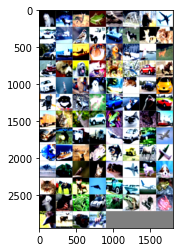

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

## Uczenie sieci - funkcja

In [0]:
nb_epoch = 10 #@param {type: "integer"}

In [0]:
def train_net(net, dataloaders, criterion, optimizer, nb_epoch, last_epoch):
    since = time.time()

    test_acc_array = []
    train_acc_array = []
    loss_array = []
    best_net = copy.deepcopy(net.state_dict())
    best_acc = 0.0

    for epoch in range(nb_epoch):  # loop over the dataset multiple times
        last_epoch = last_epoch + 1

        for phase in ['train', 'test']:
            if phase == 'train':
                net.train()
                dataloader = dataloaders[0]
            else:
                net.eval()
                dataloader = dataloaders[1]
        
            running_loss = 0.0
            running_correct = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # forward + backward + optimize
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)

                    _, prediction = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # print statistics
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(prediction == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_correct.double() / len(dataloader.dataset)

            print('Epoch %s/%s - %s Loss: %.3f Acc: %.3f' %
                (epoch + 1, nb_epoch, phase, epoch_loss, epoch_acc))
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_net = copy.deepcopy(net.state_dict())
            if phase == 'test':
                test_acc_array.append(epoch_acc)
            else:
                train_acc_array.append(epoch_acc)
            loss_array.append(epoch_loss)
    
    training_time = time.time() - since
    print('Finished Training in %.0fm %.0fs' % (training_time // 60, training_time % 60))
    print('Best test Accuracy: %.3f' % (best_acc))

    net.load_state_dict(best_net)
    return net, test_acc_array, train_acc_array, loss_array

net, test_acc_array, train_acc_array, loss_array = train_net(net, [trainloader, testloader], criterion, optimizer, nb_epoch, last_epoch)

## Uczenie sieci (kod Maćka)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

nb_epoch = 10 #@param {type: "integer"}
loss_array = []

for epoch in range(nb_epoch):  # loop over the dataset multiple times

    last_epoch = last_epoch + 1
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            last_loss = running_loss / 2000
            print('[%d, %5d] loss: %.3f' %
                (last_epoch, i + 1, last_loss))
            
            loss_array.append(last_loss)

            running_loss = 0.0
print('Finished Training')

## Zapis stanu modelu

In [0]:
from datetime import datetime

def append_timestamp(path):
    now = datetime.now()
    current_time = now.strftime("%y.%m.%d_%H:%M:%S")
    return path.replace(".", f"_{current_time}.")

In [0]:
def save_model():
    save_state = True #@param {type: "boolean"}
    path = "wlasna_best.pt" #@param {type: "string"}
    use_timestamp = True #@param {type: "boolean"}

    if save_state:
        if use_timestamp:
            path = append_timestamp(path)
        torch.save({
                    'epoch': last_epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'criterion_state_dict': criterion.state_dict(),
                    'loss': last_loss,
                    'loss_array': loss_array,
                    'acc_array': acc_array
                    }, BASE_DIR + path)

## Uczenie sieci (kod Jacka)

In [0]:
def update_classify_table(classify_table, predictions, labels):
        for lab, pred in zip(labels, predictions):
            classify_table[lab, pred] += 1

def train_step(last_epoch):
    running_loss = 0.0
    for i, (img, label) in enumerate(trainloader):
        img = img.to(device)
        label = label.to(device)
        net.train()
        optimizer.zero_grad()
        prediction = net(img)
        if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
          loss = criterion(prediction[0], label)
        else:
          loss = criterion(prediction, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss
    

def print_accuracy():
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        net.eval()
        classify_table = np.zeros((10,10))
        for i, (img, label) in enumerate(testloader):
            img = img.to(device)
            label = label.to(device)
            prediction = net(img)
            if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
              loss += criterion(prediction[0], label)
              _ , prediction = torch.max(prediction[0].data, 1)
            else:
              loss += criterion(prediction, label)
              _ , prediction = torch.max(prediction.data, 1)
            update_classify_table(classify_table, prediction, label.data)
            correct += torch.sum(prediction == label.data)

    accuracy = correct.cpu().numpy() / 10000
    print('Accuracy of the network on the 10000 test images: %.2f %%' % (
        100 * accuracy))   
    return accuracy

In [0]:
nb_epoch =  40#@param {type: "integer"}

In [0]:
counter = 0

for e in range(nb_epoch):
    last_epoch = last_epoch + 1
    running_loss = train_step(last_epoch)
    last_loss = running_loss / 500
    print('%d epoch, loss: %.4f' % (last_epoch, last_loss))
    loss_array.append(last_loss)
    curr_acc = print_accuracy()
    acc_array.append(curr_acc)
    if curr_acc > max_acc:
        save_model()
        max_acc = curr_acc
        counter = 0
    else:
        counter = counter + 1
        if counter > 2:
            break

58 epoch, loss: 0.3571
Accuracy of the network on the 10000 test images: 82.61 %
59 epoch, loss: 0.3587
Accuracy of the network on the 10000 test images: 82.58 %
60 epoch, loss: 0.3625
Accuracy of the network on the 10000 test images: 82.65 %


In [0]:
save_state = True #@param {type: "boolean"}
path = "vgg.pt" #@param {type: "string"}
use_timestamp = True #@param {type: "boolean"}

if save_state:
    if use_timestamp:
        path = append_timestamp(path)
    torch.save({
                'epoch': last_epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion_state_dict': criterion.state_dict(),
                'test_acc': test_acc_array,
                'train_acc': train_acc_array
                }, BASE_DIR + path)nb_epoch =  20#@param {type: "integer"}

for e in range(nb_epoch):
    last_epoch = last_epoch + 1
    running_loss = train_step(last_epoch)
    last_loss = running_loss / 500
    print('%d epoch, loss: %.4f' % (last_epoch, last_loss))
    loss_array.append(last_loss)
    curr_acc = print_accuracy()
    acc_array.append(curr_acc)
    if curr_acc > max_acc:
        max_acc = curr_acc
        break

## Wyniki (kod Maćka)

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * accuracy))

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

accuracy_per_class = []

for i in range(10):
    accuracy_per_class.append({
                               'class': classes[i], 
                               'accuracy': class_correct[i] / class_total[i]
                               })
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

## Wyniki (kod Maćka + kod Jacka)

In [0]:
def update_classify_table(classify_table, predictions, labels):
        for lab, pred in zip(labels, predictions):
            classify_table[lab, pred] += 1

In [0]:
correct = 0
total = 0
loss = 0.0
with torch.no_grad():
    net.eval()
    classify_table = np.zeros((10,10))
    for i, (img, label) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
        prediction = net(img)
        loss += criterion(prediction, label)
        _ , prediction = torch.max(prediction.data, 1)
        update_classify_table(classify_table, prediction, label.data)
        correct += torch.sum(prediction == label.data)

accuracy = correct.cpu().numpy() / 10000
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * accuracy))

Accuracy of the network on the 10000 test images: 78 %


## Wyniki (kod Jacka)

In [0]:
correct = 0
total = 0
loss = 0.0
with torch.no_grad():
    net.eval()
    classify_table = np.zeros((10,10))
    for i, (img, label) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
        prediction = net(img)
        if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
            loss += criterion(prediction[0], label)
        else:
            loss += criterion(prediction, label)
            
        _ , prediction = torch.max(prediction[0].data, 1)
        update_classify_table(classify_table, prediction, label.data)
        correct += torch.sum(prediction == label.data)

accuracy = correct.cpu().numpy() / 10000
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * accuracy)) 

Accuracy of the network on the 10000 test images: 82.65 %


### Zapis wyników (opcjonalne)

In [0]:
save_results_state = True #@param {type: "boolean"}
use_timestamp = True #@param {type: "boolean"}
path = "pytorch_tutorial.json" #@param {type: "string"}

from datetime import datetime
import json
import codecs

if save_results_state:
    if use_timestamp:
        path = append_timestamp(path)

    json.dump(dict(accuracy=accuracy, classify_table=accuracy_per_class),
              codecs.open(BASE_DIR + path, 'w', encoding='utf-8'))

## Wykresy

ValueError: ignored

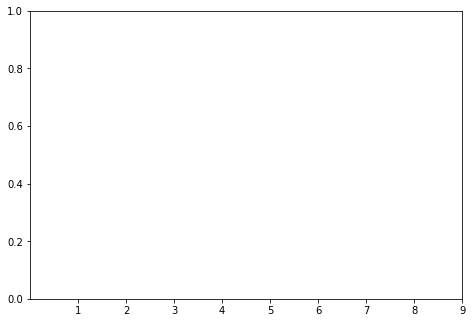

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, last_epoch + 1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(np.arange(0, last_epoch + 1, 5))

plt.scatter(epochs, loss_array)
plt.title("Wykres funkcji straty dla zbioru treningowego")
plt.xlabel("Numer epoki")
plt.ylabel("Wartość funkcji straty")
plt.show()

TypeError: ignored

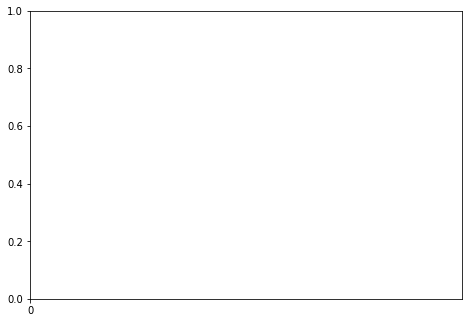

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, last_epoch + 1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(np.arange(0, last_epoch + 1))

plt.scatter(epochs, test_acc_array)
plt.title("Wykres dokładności dla zbioru walidacyjnego")
plt.xlabel("Numer epoki")
plt.ylabel("Dokładność")
plt.show()

In [0]:
import copy
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
def visualise_accuracy_by_class(classify_table):
    results = [ classify_table[i,i] / np.sum(classify_table[i, :]) for i in range(10)]

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    plt.bar(classes, results, color = ['#7e57c2', '#ffc400'])
    plt.title("Frakcja poprawnych klasyfikacji dla poszczególnych klas")
    plt.xlabel('Klasa')
    plt.ylabel('Frakcja poprawnych klasyfikacji')
    plt.xticks(classes, rotation='vertical')
    if save:
        plt.tight_layout()
        plt.savefig(path, dpi=300)
    plt.show()
    
def visualise_errors_by_class(classify_table, save=False, path=''):
    #indices = np.arange(10)
    p = list()
    table = copy.deepcopy(classify_table)
    table[np.argmax(table, 0), np.argmax(table, 1)] = 0
    p.append(plt.bar(classes, table[:, 0]))
    for i in range(1, 10):
        p.append(plt.bar(classes, table[:, i], bottom = np.sum(table[:, 0:i], 1)))

    plt.title("Błędy klasyfikacji")
    plt.xticks(classes, rotation='vertical')
    plt.xlabel("Poprawna klasa")
    plt.ylabel("Liczba błędnych klasyfikacji")
    plt.legend(classes, title = "Klasa zwracana przez sieć", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save:
        plt.tight_layout()
        plt.savefig(path, dpi=150)
    plt.show()

def visualise_errors_for_class(classify_table, class_index, save=False, path=''):
    #indices = np.arange(10)
    p = list()
    table = copy.deepcopy(classify_table)
    table[np.argmax(table, 0), np.argmax(table, 1)] = 0

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    plt.bar(classes, table[:, class_index])
    plt.xticks(classes, rotation='vertical')
    plt.title("Liczba błędnych klasyfikacji dla klasy: {}".format(class_index))
    plt.xlabel("Klasa zwracana przez sieć")
    plt.ylabel("Liczba błędnych klasyfikacji")
    if save:
        plt.tight_layout()
        plt.savefig(path, dpi=150)
    plt.show()

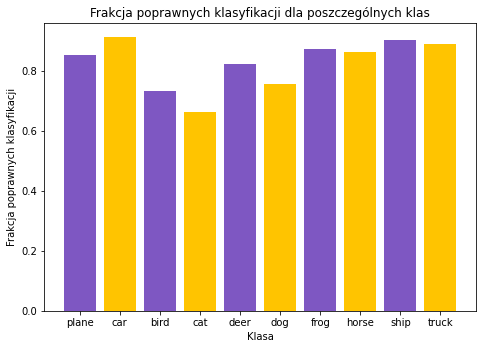

In [0]:
visualise_accuracy_by_class(classify_table, True, BASE_DIR + 'vgg-accuracy_by_class.png')

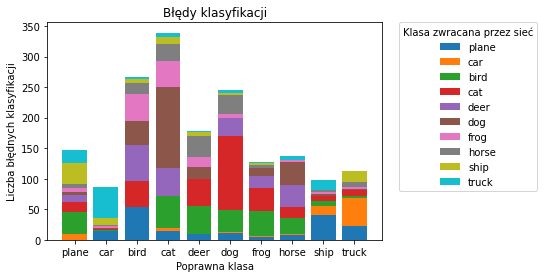

In [0]:
visualise_errors_by_class(classify_table, True, BASE_DIR + 'vgg-errors_by_class.png')

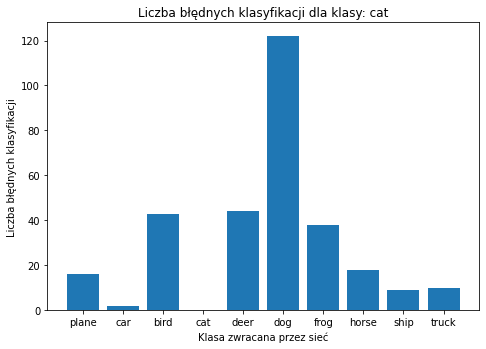

In [0]:
visualise_errors_for_class(classify_table, 3, True, BASE_DIR + 'vgg-errors_for_class.png')